# Image Classification

Work done by: Kyle Chan kxc180021 Ryan Banafshay rcb170002

We are using a Kaggle dataset from here (https://www.kaggle.com/datasets/puneet6060/intel-image-classification). It consists of about 25,000 images of size 150x150 distributed over 6 categories.

First, we will import some packages.

In [7]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

We'll build a function that will load the images from the dataset into our training and testing sets. They are already pre-split from Kaggle.

In [8]:
import os
from tqdm import tqdm
import cv2

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_names:i for i, class_names in enumerate(class_names)}

image_size = (150, 150)

def get_images_and_labels():
    datasets = ['archive/seg_train/seg_train', 'archive/seg_test/seg_test']
    output = []
    
    for dataset in datasets:
        images = []
        labels = []
        
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                img = cv2.resize((cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)), image_size)
                
                images.append(img)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output

In [9]:
(train_images, train_labels), (test_images, test_labels) = get_images_and_labels()

loading archive/seg_train/seg_train


100%|█████████████████████████████████████| 2274/2274 [00:01<00:00, 1658.95it/s]


loading archive/seg_test/seg_test


100%|███████████████████████████████████████| 510/510 [00:00<00:00, 1868.57it/s]


In [10]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state=1234)

## Data exploration

Let's explore our data and find out the shape and size of our dataset.

In [11]:
print(f'Train shape: {train_labels.shape}')
print(f'Test shape: {test_labels.shape}')
print(f'Image sizes: {image_size}')

Train shape: (14034,)
Test shape: (3000,)
Image sizes: (150, 150)


We will use Matplotlib to plot a pie graph showing the distribution of images and their respective labels, then plot a bar graph showing the proportions of the size of the training and testing dataset.

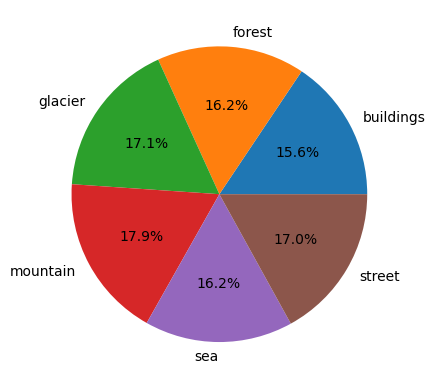

<Axes: >

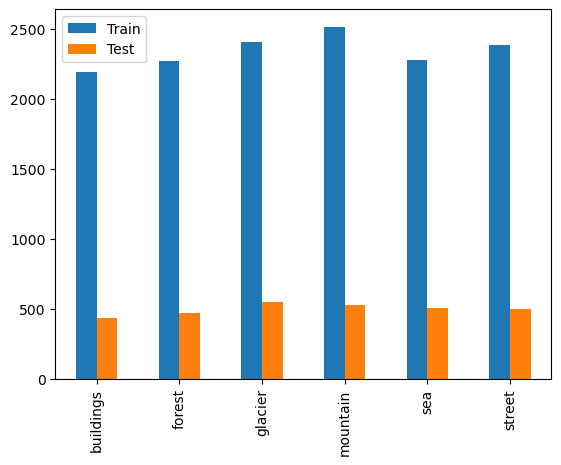

In [12]:
import matplotlib.pyplot as plt

_, train_count = np.unique(train_labels, return_counts=True)
_, test_count = np.unique(test_labels, return_counts=True)


plt.pie(train_count,
        explode=(0,0,0,0,0,0),
        labels=class_names,
        autopct='%1.1f%%')
plt.show()


df = pd.DataFrame({'Train': train_count,
              'Test': test_count},
              index=class_names,)

df.plot.bar()


As seen above, the images are labelled at a roughly equal distribution, meaning that we will have an equal amount of training to predict each category.

Next, let's see what kind of images we are working with. Below, we have created a function that will display the first 25 images of the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

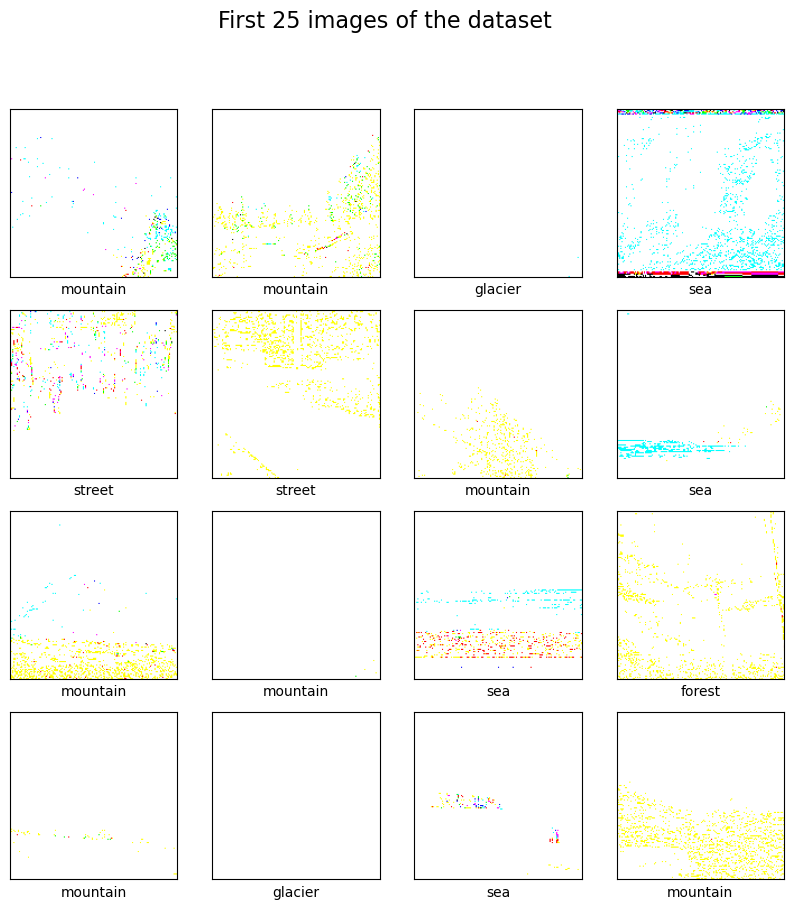

In [13]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("First 25 images of the dataset", fontsize=16)
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

As we can see, the images are extremely distorted, oversaturated, and too bright.

We now know that we must scale our data down to a visible color spectrum. We will redisplay the images after scaling down.

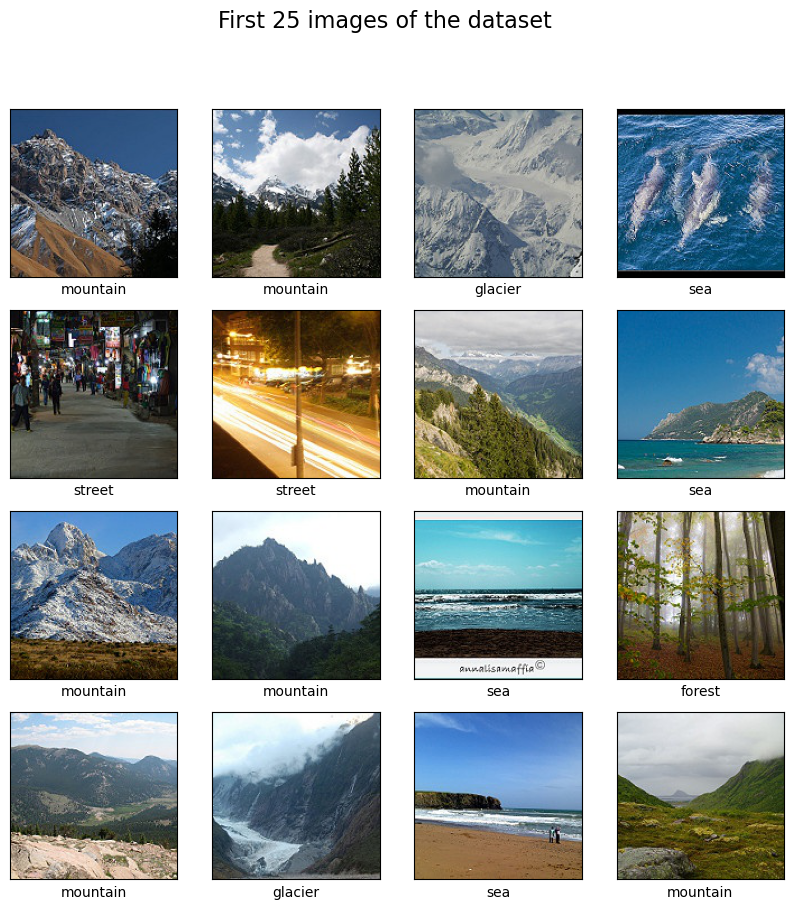

In [14]:
train_images = train_images / 255
test_images = test_images / 255

display_examples(class_names, train_images, train_labels)

## Sequential (CNN)

Now, we will create a model using Tensorflow's Keras class.

There are several layers and components to the model such as:

- Conv2D: used for 'extracting' features from the image being evaluated
- MaxPooling2D: used to reduce the image size by half
- Flatten: transforms the image being read from a 2D-array to a 1D-array of pixel values
- Relu: an activation function that, given x, will return the max between x and 0
- Softmax: set to 6 neurons in our case, corresponding to one of the 6 unique labels we want as an output

We will use the 'adam' optimizer. 'Adam' is an optimization algorithm that combines the benefits of two algorithms:

- RMSProp: (Root Mean Square Propagation) exponentialy weights past gradients the further they are from the current layer
- Momentum: takes into account the past gradient and carries forward a small portion of the previous vector so that the optimizer keeps moving in relatively the same direction

We will also use a sparse categorical crossentropy loss function, since each image should only belong to one class.

In [15]:
CNN_model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation="softmax"),
    ]
)

CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2023-04-22 12:15:46.792759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's output the layers and see the breakdown of our model's parameters.

In [16]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               1

Now, we can fit our training data to our newly created model.

In [19]:
history = CNN_model.fit(train_images, train_labels,
                    batch_size=128,
                    epochs=25,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/25
88/88 [==============================] - 150s 2s/step - loss: 1.2566 - accuracy: 0.5705 - val_loss: 0.7828 - val_accuracy: 0.7164
Epoch 2/25
88/88 [==============================] - 139s 2s/step - loss: 0.6861 - accuracy: 0.7522 - val_loss: 0.6732 - val_accuracy: 0.7471
Epoch 3/25
88/88 [==============================] - 136s 2s/step - loss: 0.5285 - accuracy: 0.8136 - val_loss: 0.6513 - val_accuracy: 0.7606
Epoch 4/25
88/88 [==============================] - 141s 2s/step - loss: 0.3718 - accuracy: 0.8741 - val_loss: 0.6093 - val_accuracy: 0.7820
Epoch 5/25
88/88 [==============================] - 129s 1s/step - loss: 0.2243 - accuracy: 0.9318 - val_loss: 0.7446 - val_accuracy: 0.7421
Epoch 6/25
88/88 [==============================] - 142s 2s/step - loss: 0.1489 - accuracy: 0.9587 - val_loss: 0.6833 - val_accuracy: 0.7820
Epoch 7/25
88/88 [==============================] - 132s 2s/step - loss: 0.0800 - accuracy: 0.9822 - val_loss: 0.7619 - val_accuracy: 0.7734
Epoch 8/25
88

We can see that our model has reached a peak accuracy of 99%, but let's plot the model's accuracy history over time to further analyze.

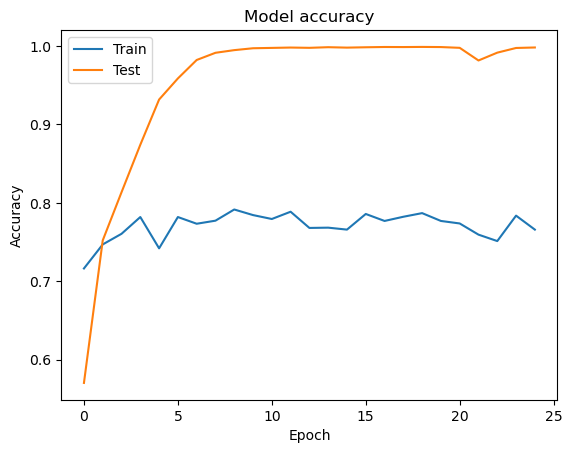

In [20]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

As shown above, the model's training accuracy seems to plateau very early, but our testing prediction accuracy continued to approach 100%. We believe that this may actually be a positive sign, since it appears that the model is generalizing the dataset better to the new data. The model does not seem like it is memorizing the training data, therefore we have determined that the model is not overfitting.

# Pretrained Model

A pre-trained model is a saved network that was previously trained on with some other large image classification dataset. For this part, we will use MobileNetV2. This is a model with a convolutional neural network architecture that tailors its performace around mobile devices.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create the base model from the pre-trained model MobileNet V2. This model is built completely independent from our image dataset.

In [24]:
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Adjusting the model to work for our image size and displaying the summary of the model.

In [25]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [26]:
# manipulating data to make model more accurate.
prediction_layer = tf.keras.layers.Dense(1)

### Transfer Learning

We will be using the previously built MobileNet model, but will add a new classifier, which will be trained from scratch, so that we can repurpose the feature maps learned previously for the dataset.

In [27]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_images,
                    epochs=25)

The results here were not great, but that very well could be due to the image set that we used rather than the model itself. I think if I ran with more epochs it would come out with a higher accuracy, but when I attempted to do more it crashed my machine.

# Analysis

Our CNN architecture showed enough positive signs for us to determine it was the best model. Our accuracy started low, but once we go to the later epochs, our accuracy continued to increase to an incredibely high value. The model seems to not be overfitting as it is not memorizing the training data.

We also used the MobileNet V2 pretrained model and used to transfer learning to fine tune the pre-trained model on our new data. This was not very successful for us with a much lower accuracy than our previous architectures that we attempted. A big part of this might be the pretrained model that we decided to use and how decided to fine tune that model. Though, it is nice to have all the features all built in when loaded in, which saves a lot of time and resources which makes this method stil the most practical.

Unless you have a very specific dataset, I think its best to build your own model. This may not be as efficent as building off a pretrained model, but building your own will allow you . Obviously the downside to building your own model is that it is more prone to error, unless you use an incredibly large dataset, which would require a particularly power machine to run.